In [3]:
import torch
import numpy as np
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import matplotlib.image as mpimg
import os
import cv2
from tqdm import tqdm
from functools import partial
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ModuleNotFoundError: No module named 'tqdm'

In [13]:
class FLYDataset(Dataset):
    def __init__(self, path_to_data, mode = "training", cam = 0):

        # save selected camera and init lists
        self.cam = cam
        self.img_paths = []
        self.annotations = []
        self.H = 480
        self.W = 980

        # e.g path to the data, different classes, number of images per class, or image IDs per class
        if(mode != "testing" and mode != "training"):
            raise ValueError("No such kind of data available")

        #Create path from path and parameter training/test
        full_path = os.path.join(path_to_data, mode, f"cam{cam}")
        # check if path exists. Path to data and kind are user inputs.
        if not os.path.isdir(full_path):
            raise FileExistsError(f"Wrong path {full_path}")

        # get the path to the annotation file and the path to the images
        annotation_file_path = os.path.join(full_path, "annotations", "annotations.npz")
        image_path = os.path.join(full_path, "images")
        # check if path exists. 
        if not os.path.isfile(annotation_file_path):
            raise FileExistsError(f"Wrong path to annotation file {annotation_file_path}")
        if not os.path.isdir(image_path):
            raise FileExistsError(f"Wrong path {image_path}")
        
        # load annotations
        annotations = np.load(annotation_file_path)
        self.annotations.append(annotations['points2d'])

        for image_name in sorted(os.listdir(image_path)):
                # get the label as an int and the path of the image
                if(image_name.endswith(".jpg")):
                    self.img_paths.append(os.path.join(image_path, image_name))

        if len(self.img_paths) != len(self.annotations):
            raise IndexError("Number of images and annotations must be the same")


    def __getitem__(self, idx):
        # returning a single image per given index idx and its corresponding label

        #Check if the index exists and read in the image. Return both the image and the label as torch tensors
        if(idx >= len(self.img_paths)):
            raise LookupError("Invalid index for image")
        img = cv2.imread(self.img_paths[idx], cv2.IMREAD_GRAYSCALE)
        
        #creating torch tensor and normalizing,a lso adding front channel to match requirement from torch
        t_img = torch.tensor(img, dtype=torch.float32) / 255
        t_img = t_img.unsqueeze(0)

        # prepare annotations as tensor
        annotation = self.annotations[idx]
        t_anno = torch.tensor(annotation, dtype=torch.float32)

        return t_img, t_anno
    
    def __len__(self):
        # returning whole length of the dataset / number of images
        return len(self.img_paths)
    
    def __getvisual__(self, idx = 0):
        if(idx >= len(self.img_paths)):
            raise LookupError("Invalid index for image")
        img = cv2.imread(self.img_paths[idx], cv2.IMREAD_GRAYSCALE)
        annotation = self.annotations[idx]
        annotation[0,:] *= self.W
        annotation[0,:] *= self.H
        
        return img, annotation

       

(38, 2)


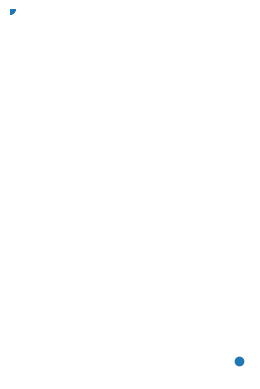

In [ ]:
dataset = FLYDataset("/home/maurrow/Documents/Uni_Projects/uzk_cvproject/data")
plt.axis('off')
x, y = dataset.__getvisual__()
print(y.shape)
plt.imshow(x, cmap="grey")
plt.scatter(y[:,0], y[:,1])

plt.show(block=True)

In [ ]:
class CNN_Fly(nn.Module):
    def __init__(self, input_size, embedding_size):
        super().__init__()

        self.embedding_size = embedding_size
        self.input_size = input_size

        """Encoder"""
        self.e1 = nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1)
        self.activation = nn.ReLU()
        self.e2 = nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1)
        self.e3 = nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1)
        self.e4 = nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1)

        """Bottleneck"""
        self.flatten  = nn.Flatten()
        self.linear = nn.Linear(3136, 2*embedding_size)

        """Decoder"""
        self.d1 = torch.nn.Linear(embedding_size, 3136)
        self.reshape = Reshape(-1, 64, 7, 7)
        self.d2 = nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1)
        self.d3 = nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1)
        self.d4 = nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0)
        self.d5 = nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0)
        self.trim = Trim(input_size, input_size)
        self.last_activation = nn.Sigmoid()


    def encoder(self, inputs):
        x = self.e1(inputs)
        x = self.activation(x)
        x = self.e2(x)
        x = self.activation(x)
        x = self.e3(x)
        x = self.activation(x)
        x = self.e4(x)
        x = self.activation(x)
        return x

    def decoder(self, x):
        x = self.d1(x)
        x = self.activation(x)
        x = self.d2(self.reshape(x))
        x = self.activation(x)
        x = self.d3(x)
        x = self.activation(x)
        x = self.d4(x)
        x = self.activation(x)
        x = self.d5(x)

        """Output"""
        outputs = self.last_activation(self.trim(x))
        return outputs
    
    # apply std and epsilon to make data more noisy
    def reparametrization(self, mu, logsig):
        std = torch.exp(logsig * 0.5)
        noise = torch.randn_like(std)
        return mu + (std * noise)
    
    # calculate loss by combining mse and kld
    @staticmethod
    def loss_function(pred_x, inputs, pred_mean, pred_logvar, kl_weight=1):
        rec_loss = F.mse_loss(pred_x, inputs)
        kld_loss = -0.5 * torch.mean(1 + pred_logvar - pred_mean.pow(2) - pred_logvar.exp())
        loss = rec_loss + kl_weight * kld_loss

        return {'loss': loss, 'Reconstruction_Loss': rec_loss.detach(), 'KLD': -kld_loss.detach() }
    
        
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor) of generated samples (shape num_samples, input_size)
        """
    def generate_from_latent(self, num_samples:int, current_device: int, **kwargs):
        self.eval()
        with torch.no_grad():
            # create random samples from std
            samples = torch.randn(num_samples, self.embedding_size).to(current_device)
            # decode
            generated = self.decoder(samples)
            return generated


    def forward(self, inputs):
        """Encoder"""
        x = self.encoder(inputs)

        """Bottleneck"""
        x = self.linear(self.flatten(x))

        # the mu logvar split as defined in the task
        mu, logvar = torch.chunk(x, 2, dim=1)
        noisy = self.reparametrization(mu, logvar)

        """Decoder"""
        outputs = self.decoder(noisy)

        return outputs, noisy, mu, logvar

    def get_embedding(self, inputs):
        """Encoder"""
        x = self.encoder(inputs)

        """Bottleneck"""
        x = self.linear(self.flatten(x))

        # the mu logvar split as defined in the task
        mu, logvar = torch.chunk(x, 2, dim=1)
        noisy = self.reparametrization(mu, logvar)

        return noisy


In [ ]:
embedding_size = 64
kl_weight = 0.01
learning_rate = 1e-2
epochs = 101

vae = CNN_VAE(input_size, embedding_size).to(device)
optimizer = optim.SGD(vae.parameters(), lr=learning_rate, momentum=0.9)

print(f'\nVAE -- With LR = {learning_rate} AND KL_WEIGHT = {kl_weight}')

vae.zero_grad()
history_loss = []
history_val_loss = []

for epoch in range(epochs):
    running_loss = 0.0
    running_recons_loss = 0.0
    running_kld_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, _ = data[0].to(device), data[1].to(device)
        if inputs.dim() == 3:
            inputs = inputs.unsqueeze(1)
        optimizer.zero_grad()
        pred_x, _, pred_mean, pred_logvar = vae(inputs)
        loss = vae.loss_function(pred_x, inputs, pred_mean, pred_logvar, kl_weight=kl_weight)
        loss['loss'].backward()
        optimizer.step()

        running_loss += loss['loss'].item()
        running_recons_loss += loss['Reconstruction_Loss'].item()
        running_kld_loss += loss['KLD'].item()
    # output loss every 10 epochs
    if epoch % 10 == 0:
        with torch.no_grad():
            running_val_loss = 0.0
            running_val_recons_loss = 0.0
            running_val_kld_loss = 0.0
            for j, data in enumerate(test_dataloader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                if inputs.dim() == 3:
                    inputs = inputs.unsqueeze(1)
                pred_x, _, pred_mean, pred_logvar = vae(inputs)
                loss = vae.loss_function(pred_x, inputs, pred_mean, pred_logvar, kl_weight=kl_weight)

                running_val_loss += loss['loss'].item()
                running_val_recons_loss += loss['Reconstruction_Loss'].item()
                running_val_kld_loss += loss['KLD'].item()

            print(f'[{epoch + 1}] Loss: {running_loss / (i + 1):.5f} - Recons loss: {running_recons_loss / (i + 1):.5f}  '
                 f'- KLD: {running_kld_loss / (i + 1):.5f} || Val loss: {running_val_loss / (j + 1):.5f} '
                 f'- Recons val loss: {running_val_recons_loss / (j + 1):.5f}  - KLD: {running_val_kld_loss / (j + 1):.5f}')

        history_loss.append(running_loss / (i + 1))
        history_val_loss.append(running_val_loss / (j + 1))
        running_loss = 0.0

    # plot every n-th epoch
    if epoch % plot_nepoch == 0:
        rd_i = np.random.randint(inputs.shape[0])
        fig, axes = plt.subplots(1, 2)
        fig.suptitle(f'VAE - epoch {epoch} - loss {running_val_loss / (j + 1):.5f}')
        axes[0].imshow(inputs[rd_i].reshape((28, 28)).detach().cpu().numpy())
        axes[1].imshow(pred_x[rd_i].reshape((28, 28)).detach().cpu().numpy())
        plt.savefig(os.path.join(path_, f'cnnvae_ex_epoch{epoch}_emb-{embedding_size}.png'))

print('-- End training, saving model')
torch.save(vae.state_dict(), os.path.join(path_, f'mnist_cnnvae_emb-{embedding_size}_klweight-{kl_weight}.pt'))

# visualization
plt.figure()
plt.suptitle('Losses VAE')
plt.plot(np.arange(1, len(history_loss) * 10 + 1, 10), history_loss, label='loss')
plt.plot(np.arange(1, len(history_loss) * 10 + 1, 10), history_val_loss, '--', label='val_loss')
plt.legend()
plt.savefig(os.path.join(path_, f'losses_emb-{embedding_size}_klweight-{kl_weight}.png'))
plt.show()